In [1]:
import os
print(os.getcwd())
def update_working_directory():
    from pathlib import Path
    p = Path(os.getcwd()).parents[0]
    os.chdir(p)
    print(p)
update_working_directory()

/Users/admin/Projects/doggo/notebooks
/Users/admin/Projects/doggo


In [2]:
import numpy as np
from tqdm import tqdm
import json
import sys

from src.data.env_dog import get_env_actions, get_env_space, env_reset, get_happiness, env_step, env_render

from src.features.rl_tools import init_Q, init_steps_per_state, get_epsilon, get_alpha, epsilon_greedy, update_steps_per_state
from src.features.rl_tools_during_training import get_default_checking, launch_checking, save_models, display_analyse_Q

from src.features.rl_tools_sarsa import update_Q_SARSA

from src.utils.plots import get_info_params
from src.visualization.rl_plots_evolution import plot_evolution_reward, plot_evolution_steps
from src.visualization.plot_happiness import plot_evolution_happiness

In [3]:
method = 'sarsa'

# Parametrisation
params = json.loads(open('src/models/{}.json'.format(method)).read())
print(params)

In [5]:
info_params = get_info_params({
    'method': params['method']
    , 'n_episodes': 0
    , 'nmax_steps': params['nmax_steps']
    , 'init_epsilon': params['init_epsilon']
    , 'init_alpha': params['init_alpha']
    , 'gamma': params['gamma']
})

In [6]:
# Initializing environment
action_dict, n_actions = get_env_actions()
_, n_states = get_env_space()

# Initializing the Q-matrix
Q = init_Q(n_actions, params['init_Q_type'])
Q_saved = Q.copy()

steps_per_state = init_steps_per_state()

# Visualisation
n_episodes_save = int(np.ceil(params['n_episodes'] / 100))

# Initializing the reward
evo_training = {
    'evo_avg_reward_per_step': []
    , 'evo_n_steps': []
    , 'evo_avg_happiness': []
    , 'checking': get_default_checking()
}

In [7]:
for episode in tqdm(range(params['n_episodes'])):
    # episode = 0

    evo_episode = {
        'n_episode_steps': 0
        , 'done': False
        , 'episode_sum_reward': 0
        , 'evolution_sum_happiness': 0
    }

    state1 = env_reset()
    evo_episode['evolution_sum_happiness'] += get_happiness(state1)

    # Update parameters
    epsilon = get_epsilon(steps_per_state[state1['state_id']], params['init_epsilon'])
    evo_training['checking']['evo_epsilon'].append(epsilon)
    alpha = get_alpha(steps_per_state[state1['state_id']], params['init_alpha'])
    evo_training['checking']['evo_alpha'].append(alpha)

    action1 = epsilon_greedy(Q, state1['state_id'], n_actions, epsilon)
    steps_per_state = update_steps_per_state(steps_per_state, state1['state_id'])

    while (not evo_episode['done']) and (evo_episode['n_episode_steps'] < params['nmax_steps']):

        # Getting the next state
        state2, reward1, evo_episode['done'], info = env_step(state1, action1)

        evo_episode['episode_sum_reward'] += reward1
        evo_episode['evolution_sum_happiness'] += get_happiness(state2)
        evo_training['checking']['empirical_return'].append(reward1)
        evo_training['checking']['predicted_value'].append(Q[state1['state_id']][action1])

        # Update parameters
        epsilon = get_epsilon(steps_per_state[state2['state_id']], params['init_epsilon'])
        evo_training['checking']['evo_epsilon'].append(epsilon)

        # Choosing the next action
        action2 = epsilon_greedy(Q, state2['state_id'], n_actions, epsilon)
        steps_per_state = update_steps_per_state(steps_per_state, state2['state_id'])

        # Learning the Q-value
        method_params = {'alpha': alpha, 'gamma': params['gamma']}
        Q = update_Q_SARSA(Q, state1['state_id'], action1, reward1, state2['state_id'], action2, method_params)

        # Updating the respective values
        state1 = state2
        action1 = action2
        evo_episode['n_episode_steps'] += 1


    print('Episode {}, Avg Reward : {}, Timesteps: {}, Epsilon: {}, Alpha: {}'.format(
        episode + 1,
        evo_episode['episode_sum_reward'] / evo_episode['n_episode_steps'],
        evo_episode['n_episode_steps'], epsilon, alpha))


    evo_training['evo_avg_reward_per_step'].append(evo_episode['episode_sum_reward'] / evo_episode['n_episode_steps'])
    evo_training['evo_n_steps'].append(evo_episode['n_episode_steps'])
    evo_training['evo_avg_happiness'].append(evo_episode['evolution_sum_happiness'] / evo_episode['n_episode_steps'])

    # display_analyse_Q(Q)

  0%|          | 19/10000 [00:00<01:48, 91.74it/s] 

Episode 1, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.1, Alpha: 0.5
Episode 2, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.09090909090909091, Alpha: 0.45454545454545453
Episode 3, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.1, Alpha: 0.4166666666666667
Episode 4, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.1, Alpha: 0.3846153846153846
Episode 5, Avg Reward : -8.743727272727272, Timesteps: 110, Epsilon: 0.1, Alpha: 0.35714285714285715
Episode 6, Avg Reward : -6.8408633093525175, Timesteps: 139, Epsilon: 0.1, Alpha: 0.3333333333333333
Episode 7, Avg Reward : -8.735272727272728, Timesteps: 110, Epsilon: 0.1, Alpha: 0.3125
Episode 8, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.09090909090909091, Alpha: 0.29411764705882354
Episode 9, Avg Reward : -11.894878048780487, Timesteps: 82, Epsilon: 0.1, Alpha: 0.2777777777777778
Episode 10, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.08333333333333334, Alpha: 0.2631578947368421
Episode 11, Avg Reward

  0%|          | 32/10000 [00:00<02:20, 70.76it/s]

Episode 23, Avg Reward : -3.9892241379310347, Timesteps: 232, Epsilon: 0.1, Alpha: 0.15625
Episode 24, Avg Reward : -3.151958041958042, Timesteps: 286, Epsilon: 0.07692307692307693, Alpha: 0.15151515151515152
Episode 25, Avg Reward : -3.989353448275862, Timesteps: 232, Epsilon: 0.1, Alpha: 0.14705882352941177
Episode 26, Avg Reward : -5.021989247311828, Timesteps: 186, Epsilon: 0.07142857142857144, Alpha: 0.14285714285714285
Episode 27, Avg Reward : -3.647103174603175, Timesteps: 252, Epsilon: 0.09090909090909091, Alpha: 0.1388888888888889
Episode 28, Avg Reward : -6.067388535031847, Timesteps: 157, Epsilon: 0.08333333333333334, Alpha: 0.13513513513513511
Episode 29, Avg Reward : -3.6937246963562753, Timesteps: 247, Epsilon: 0.07692307692307693, Alpha: 0.13157894736842105
Episode 30, Avg Reward : -3.6273122529644266, Timesteps: 253, Epsilon: 0.1, Alpha: 0.12820512820512822
Episode 31, Avg Reward : -6.225882352941176, Timesteps: 153, Epsilon: 0.09090909090909091, Alpha: 0.125
Episode 32

  0%|          | 44/10000 [00:00<02:49, 58.90it/s]


Episode 37, Avg Reward : -3.3921052631578945, Timesteps: 266, Epsilon: 0.08333333333333334, Alpha: 0.10869565217391305
Episode 38, Avg Reward : -7.259318181818181, Timesteps: 132, Epsilon: 0.07692307692307693, Alpha: 0.10638297872340426
Episode 39, Avg Reward : -3.3161992619926193, Timesteps: 271, Epsilon: 0.07692307692307693, Alpha: 0.10416666666666667
Episode 40, Avg Reward : -5.630710059171597, Timesteps: 169, Epsilon: 0.07142857142857144, Alpha: 0.1020408163265306
Episode 41, Avg Reward : -3.2337366548042707, Timesteps: 281, Epsilon: 0.1, Alpha: 0.1
Episode 42, Avg Reward : -5.328983050847458, Timesteps: 177, Epsilon: 0.07142857142857144, Alpha: 0.09803921568627452
Episode 43, Avg Reward : -1.920294784580498, Timesteps: 441, Epsilon: 0.06666666666666667, Alpha: 0.09615384615384615
Episode 44, Avg Reward : -2.8624193548387096, Timesteps: 310, Epsilon: 0.0625, Alpha: 0.09433962264150944
Episode 45, Avg Reward : -1.5710556621880993, Timesteps: 521, Epsilon: 0.1, Alpha: 0.092592592592

  1%|          | 55/10000 [00:00<03:47, 43.69it/s]

Episode 48, Avg Reward : -1.6826441351888664, Timesteps: 503, Epsilon: 0.07692307692307693, Alpha: 0.08771929824561403
Episode 49, Avg Reward : -2.0114285714285716, Timesteps: 420, Epsilon: 0.05882352941176471, Alpha: 0.08620689655172414
Episode 50, Avg Reward : -3.3828195488721806, Timesteps: 266, Epsilon: 0.05882352941176471, Alpha: 0.0847457627118644
Episode 51, Avg Reward : -2.57067055393586, Timesteps: 343, Epsilon: 0.1, Alpha: 0.08333333333333333
Episode 52, Avg Reward : -4.679547738693468, Timesteps: 199, Epsilon: 0.05555555555555556, Alpha: 0.0819672131147541
Episode 53, Avg Reward : -1.9802088167053367, Timesteps: 431, Epsilon: 0.052631578947368425, Alpha: 0.08064516129032258
Episode 54, Avg Reward : -2.6922560975609753, Timesteps: 328, Epsilon: 0.1, Alpha: 0.07936507936507936
Episode 55, Avg Reward : -1.018845598845601, Timesteps: 693, Epsilon: 0.1, Alpha: 0.078125
Episode 56, Avg Reward : -8.19965811965812, Timesteps: 117, Epsilon: 0.06666666666666667, Alpha: 0.0769230769230

  1%|          | 60/10000 [00:01<03:40, 45.18it/s]

Episode 57, Avg Reward : -3.1755123674911663, Timesteps: 283, Epsilon: 0.1, Alpha: 0.07575757575757576
Episode 58, Avg Reward : -3.4159701492537318, Timesteps: 268, Epsilon: 0.05, Alpha: 0.07462686567164178
Episode 59, Avg Reward : -7.65368, Timesteps: 125, Epsilon: 0.1, Alpha: 0.07352941176470588
Episode 60, Avg Reward : -1.6055905511811026, Timesteps: 508, Epsilon: 0.0625, Alpha: 0.07246376811594203
Episode 61, Avg Reward : -4.679547738693468, Timesteps: 199, Epsilon: 0.047619047619047616, Alpha: 0.07142857142857142
Episode 62, Avg Reward : -1.155515695067265, Timesteps: 669, Epsilon: 0.09090909090909091, Alpha: 0.07042253521126761
Episode 63, Avg Reward : -2.051722488038277, Timesteps: 418, Epsilon: 0.1, Alpha: 0.06944444444444445
Episode 64, Avg Reward : -2.9733443708609273, Timesteps: 302, Epsilon: 0.05555555555555556, Alpha: 0.0684931506849315
Episode 65, Avg Reward : -4.001206896551724, Timesteps: 232, Epsilon: 0.1, Alpha: 0.06756756756756756

  1%|          | 70/10000 [00:01<04:09, 39.84it/s]


Episode 66, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.1, Alpha: 0.06666666666666667
Episode 67, Avg Reward : -5.791524390243901, Timesteps: 164, Epsilon: 0.06666666666666667, Alpha: 0.06578947368421052
Episode 68, Avg Reward : -1.5727447216890589, Timesteps: 521, Epsilon: 0.1, Alpha: 0.06493506493506493
Episode 69, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.07142857142857144, Alpha: 0.06410256410256411
Episode 70, Avg Reward : -1.0707988587731805, Timesteps: 701, Epsilon: 0.07142857142857144, Alpha: 0.06329113924050632
Episode 71, Avg Reward : -2.2379328165374672, Timesteps: 387, Epsilon: 0.06666666666666667, Alpha: 0.0625
Episode 72, Avg Reward : -3.2814748201438864, Timesteps: 278, Epsilon: 0.045454545454545456, Alpha: 0.0617283950617284


  1%|          | 83/10000 [00:01<04:31, 36.57it/s]

Episode 73, Avg Reward : -1.5467424242424246, Timesteps: 528, Epsilon: 0.04347826086956522, Alpha: 0.06097560975609757
Episode 74, Avg Reward : -1.8010389610389606, Timesteps: 462, Epsilon: 0.1, Alpha: 0.06024096385542168
Episode 75, Avg Reward : -1.5437404580152665, Timesteps: 524, Epsilon: 0.04166666666666667, Alpha: 0.05952380952380952
Episode 76, Avg Reward : -3.9892241379310347, Timesteps: 232, Epsilon: 0.09090909090909091, Alpha: 0.058823529411764705
Episode 77, Avg Reward : -1.7828017241379308, Timesteps: 464, Epsilon: 0.09090909090909091, Alpha: 0.05813953488372093
Episode 78, Avg Reward : -1.2503338632750405, Timesteps: 629, Epsilon: 0.052631578947368425, Alpha: 0.0574712643678161
Episode 79, Avg Reward : -5.5953846153846145, Timesteps: 169, Epsilon: 0.08333333333333334, Alpha: 0.056818181818181816
Episode 80, Avg Reward : -1.7732908704883223, Timesteps: 471, Epsilon: 0.08333333333333334, Alpha: 0.056179775280898875
Episode 81, Avg Reward : -1.6681174089068818, Timesteps: 494,

  1%|          | 87/10000 [00:01<05:06, 32.39it/s]

Episode 84, Avg Reward : -1.7386723768736623, Timesteps: 467, Epsilon: 0.05, Alpha: 0.05376344086021505
Episode 85, Avg Reward : -1.7785470085470085, Timesteps: 468, Epsilon: 0.05882352941176471, Alpha: 0.05319148936170213
Episode 86, Avg Reward : -2.566109510086455, Timesteps: 347, Epsilon: 0.047619047619047616, Alpha: 0.05263157894736842
Episode 87, Avg Reward : -0.8827941176470577, Timesteps: 816, Epsilon: 0.05555555555555556, Alpha: 0.052083333333333336
Episode 88, Avg Reward : -2.852475884244373, Timesteps: 311, Epsilon: 0.052631578947368425, Alpha: 0.051546391752577324
Episode 89, Avg Reward : -6.471836734693877, Timesteps: 147, Epsilon: 0.045454545454545456, Alpha: 0.0510204081632653
Episode 90, Avg Reward : -0.8784577723378216, Timesteps: 817, Epsilon: 0.04, Alpha: 0.050505050505050504


  1%|          | 95/10000 [00:02<05:28, 30.19it/s]

Episode 91, Avg Reward : -1.5467424242424246, Timesteps: 528, Epsilon: 0.038461538461538464, Alpha: 0.05
Episode 92, Avg Reward : -0.9133844189016602, Timesteps: 783, Epsilon: 0.037037037037037035, Alpha: 0.04950495049504951
Episode 93, Avg Reward : -1.2901652892561983, Timesteps: 605, Epsilon: 0.09090909090909091, Alpha: 0.04901960784313726
Episode 94, Avg Reward : -1.5467424242424246, Timesteps: 528, Epsilon: 0.03571428571428572, Alpha: 0.04854368932038835
Episode 95, Avg Reward : -3.3610074626865667, Timesteps: 268, Epsilon: 0.034482758620689655, Alpha: 0.04807692307692307
Episode 96, Avg Reward : -7.65368, Timesteps: 125, Epsilon: 0.09090909090909091, Alpha: 0.047619047619047616
Episode 97, Avg Reward : -3.992652173913043, Timesteps: 230, Epsilon: 0.05, Alpha: 0.04716981132075472


  1%|          | 104/10000 [00:02<04:47, 34.44it/s]

Episode 98, Avg Reward : -1.6067058823529412, Timesteps: 510, Epsilon: 0.03333333333333333, Alpha: 0.04672897196261683
Episode 99, Avg Reward : -4.238211009174313, Timesteps: 218, Epsilon: 0.03225806451612903, Alpha: 0.046296296296296294
Episode 100, Avg Reward : -1.4929670329670335, Timesteps: 546, Epsilon: 0.03125, Alpha: 0.04587155963302752
Episode 101, Avg Reward : -1.6741869918699184, Timesteps: 492, Epsilon: 0.030303030303030307, Alpha: 0.045454545454545456
Episode 102, Avg Reward : -3.7181300813008127, Timesteps: 246, Epsilon: 0.1, Alpha: 0.04504504504504505
Episode 103, Avg Reward : -5.35784090909091, Timesteps: 176, Epsilon: 0.029411764705882356, Alpha: 0.044642857142857144
Episode 104, Avg Reward : -1.4873636363636358, Timesteps: 550, Epsilon: 0.07692307692307693, Alpha: 0.04424778761061947
Episode 105, Avg Reward : -2.527528735632184, Timesteps: 348, Epsilon: 0.0625, Alpha: 0.043859649122807015
Episode 106, Avg Reward : -0.773789237668161, Timesteps: 892, Epsilon: 0.04761904

  1%|          | 112/10000 [00:02<04:58, 33.09it/s]

Episode 107, Avg Reward : -1.5727447216890589, Timesteps: 521, Epsilon: 0.1, Alpha: 0.04310344827586207
Episode 108, Avg Reward : -2.048992805755396, Timesteps: 417, Epsilon: 0.09090909090909091, Alpha: 0.042735042735042736
Episode 109, Avg Reward : -1.543686200378072, Timesteps: 529, Epsilon: 0.045454545454545456, Alpha: 0.0423728813559322
Episode 110, Avg Reward : -8.735272727272728, Timesteps: 110, Epsilon: 0.08333333333333334, Alpha: 0.04201680672268907
Episode 111, Avg Reward : -2.852475884244373, Timesteps: 311, Epsilon: 0.04347826086956522, Alpha: 0.041666666666666664
Episode 112, Avg Reward : -1.6324554455445528, Timesteps: 505, Epsilon: 0.04166666666666667, Alpha: 0.04132231404958678
Episode 113, Avg Reward : -1.5470454545454548, Timesteps: 528, Epsilon: 0.04, Alpha: 0.04098360655737705
Episode 114, Avg Reward : -1.543686200378072, Timesteps: 529, Epsilon: 0.038461538461538464, Alpha: 0.04065040650406504

  1%|          | 119/10000 [00:02<06:07, 26.88it/s]


Episode 115, Avg Reward : -1.543686200378072, Timesteps: 529, Epsilon: 0.037037037037037035, Alpha: 0.04032258064516129
Episode 116, Avg Reward : 0.48420833333332947, Timesteps: 1440, Epsilon: 0.02127659574468085, Alpha: 0.04
Episode 117, Avg Reward : -1.0446473029045649, Timesteps: 723, Epsilon: 0.07142857142857144, Alpha: 0.03968253968253968
Episode 118, Avg Reward : -2.097941176470588, Timesteps: 408, Epsilon: 0.03571428571428572, Alpha: 0.03937007874015748
Episode 119, Avg Reward : -1.7310187110187123, Timesteps: 481, Epsilon: 0.034482758620689655, Alpha: 0.0390625
Episode 120, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.07692307692307693, Alpha: 0.03875968992248062
Episode 121, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.07142857142857144, Alpha: 0.038461538461538464
Episode 122, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.06666666666666667, Alpha: 0.03816793893129771
Episode 123, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0625, Alpha: 0.03787878787878788
Episode

  2%|▏         | 156/10000 [00:03<03:32, 46.36it/s]


Episode 132, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.04, Alpha: 0.03546099290780142
Episode 133, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.038461538461538464, Alpha: 0.035211267605633804
Episode 134, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.037037037037037035, Alpha: 0.03496503496503496
Episode 135, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.03571428571428572, Alpha: 0.034722222222222224
Episode 136, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.034482758620689655, Alpha: 0.034482758620689655
Episode 137, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.03333333333333333, Alpha: 0.03424657534246575
Episode 138, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.03225806451612903, Alpha: 0.034013605442176874
Episode 139, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.03125, Alpha: 0.03378378378378378
Episode 140, Avg Reward : -1.5252149532710284, Timesteps: 535, Epsilon: 0.028571428571428574, Alpha: 0.03355704697986577
Episode 141, Avg Reward : -19.755, Timeste

  2%|▏         | 182/10000 [00:03<02:33, 64.04it/s]


Episode 166, Avg Reward : -1.5165555555555548, Timesteps: 540, Epsilon: 0.09090909090909091, Alpha: 0.02857142857142857
Episode 167, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.018518518518518517, Alpha: 0.028409090909090908
Episode 168, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.018181818181818184, Alpha: 0.02824858757062147
Episode 169, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.01785714285714286, Alpha: 0.028089887640449437
Episode 170, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.017543859649122806, Alpha: 0.02793296089385475
Episode 171, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.017241379310344827, Alpha: 0.027777777777777776
Episode 172, Avg Reward : -1.4900183486238536, Timesteps: 545, Epsilon: 0.02702702702702703, Alpha: 0.027624309392265192
Episode 173, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.01694915254237288, Alpha: 0.027472527472527472
Episode 174, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.016666666666666666, Alpha: 0.0273224043715847
E

  2%|▏         | 202/10000 [00:03<02:28, 66.13it/s]


Episode 187, Avg Reward : -1.5252149532710284, Timesteps: 535, Epsilon: 0.026315789473684213, Alpha: 0.02551020408163265
Episode 188, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.014285714285714287, Alpha: 0.025380710659898477
Episode 189, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.014084507042253523, Alpha: 0.025252525252525252
Episode 190, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.01388888888888889, Alpha: 0.02512562814070352
Episode 191, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.013698630136986302, Alpha: 0.025
Episode 192, Avg Reward : -1.4677495462794914, Timesteps: 551, Epsilon: 0.025641025641025644, Alpha: 0.02487562189054726
Episode 193, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.013513513513513514, Alpha: 0.024752475247524754
Episode 194, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.013333333333333334, Alpha: 0.02463054187192118
Episode 195, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.013157894736842106, Alpha: 0.02450980392156863
Episode 196, 

  2%|▏         | 221/10000 [00:03<02:08, 76.25it/s]


Episode 211, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.011363636363636364, Alpha: 0.022727272727272728
Episode 212, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.011235955056179775, Alpha: 0.02262443438914027
Episode 213, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.011111111111111112, Alpha: 0.022522522522522525
Episode 214, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.01098901098901099, Alpha: 0.02242152466367713
Episode 215, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.010869565217391306, Alpha: 0.022321428571428572
Episode 216, Avg Reward : -1.391906412478337, Timesteps: 577, Epsilon: 0.023809523809523808, Alpha: 0.022222222222222223
Episode 217, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.01075268817204301, Alpha: 0.022123893805309734
Episode 218, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.010638297872340425, Alpha: 0.022026431718061675
Episode 219, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.010526315789473684, Alpha: 0.021929824561403508
Episode 22

  2%|▏         | 249/10000 [00:04<01:44, 93.13it/s]

Episode 235, Avg Reward : -1.5189013035381755, Timesteps: 537, Epsilon: 0.04, Alpha: 0.020491803278688527
Episode 236, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.009259259259259259, Alpha: 0.02040816326530612
Episode 237, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.009174311926605505, Alpha: 0.02032520325203252
Episode 238, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.009090909090909092, Alpha: 0.020242914979757085
Episode 239, Avg Reward : -2.1440249999999996, Timesteps: 400, Epsilon: 0.023255813953488375, Alpha: 0.020161290322580645
Episode 240, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.009009009009009009, Alpha: 0.020080321285140562
Episode 241, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00892857142857143, Alpha: 0.02
Episode 242, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.008849557522123894, Alpha: 0.0199203187250996
Episode 243, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.008771929824561403, Alpha: 0.01984126984126984
Episode 244, Avg Reward : -3.18

  3%|▎         | 276/10000 [00:04<01:32, 104.77it/s]


Episode 263, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.007751937984496124, Alpha: 0.01838235294117647
Episode 264, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.007692307692307693, Alpha: 0.018315018315018316
Episode 265, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0076335877862595426, Alpha: 0.018248175182481754
Episode 266, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.09090909090909091, Alpha: 0.01818181818181818
Episode 267, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.007575757575757577, Alpha: 0.018115942028985508
Episode 268, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.05555555555555556, Alpha: 0.018050541516245487
Episode 269, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.007518796992481203, Alpha: 0.017985611510791366
Episode 270, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.007462686567164179, Alpha: 0.01792114695340502
Episode 271, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.007407407407407408, Alpha: 0.017857142857142856
Episode 27

  3%|▎         | 303/10000 [00:04<01:22, 117.05it/s]


Episode 291, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.006666666666666667, Alpha: 0.016666666666666666
Episode 292, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.006622516556291392, Alpha: 0.01661129568106312
Episode 293, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.006578947368421053, Alpha: 0.016556291390728478
Episode 294, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.047619047619047616, Alpha: 0.0165016501650165
Episode 295, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.006535947712418301, Alpha: 0.01644736842105263
Episode 296, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.006493506493506494, Alpha: 0.01639344262295082
Episode 297, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.08333333333333334, Alpha: 0.016339869281045753
Episode 298, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0064516129032258064, Alpha: 0.016286644951140065
Episode 299, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.045454545454545456, Alpha: 0.016233766233766232

  3%|▎         | 330/10000 [00:04<01:29, 108.34it/s]


Episode 313, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.006060606060606061, Alpha: 0.015527950310559004
Episode 314, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.006024096385542168, Alpha: 0.015479876160990714
Episode 315, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005988023952095809, Alpha: 0.0154320987654321
Episode 316, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.04166666666666667, Alpha: 0.015384615384615385
Episode 317, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005952380952380952, Alpha: 0.015337423312883436
Episode 318, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00591715976331361, Alpha: 0.015290519877675839
Episode 319, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0058823529411764705, Alpha: 0.015243902439024392
Episode 320, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005847953216374269, Alpha: 0.015197568389057751
Episode 321, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.04, Alpha: 0.015151515151515152
Episode 322, 

  4%|▎         | 356/10000 [00:05<01:26, 111.67it/s]


Episode 340, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005434782608695653, Alpha: 0.014326647564469915
Episode 341, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005405405405405406, Alpha: 0.014285714285714285
Episode 342, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005376344086021505, Alpha: 0.014245014245014245
Episode 343, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.06666666666666667, Alpha: 0.014204545454545454
Episode 344, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005347593582887701, Alpha: 0.0141643059490085
Episode 345, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005319148936170213, Alpha: 0.014124293785310734
Episode 346, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005291005291005292, Alpha: 0.014084507042253521
Episode 347, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.03571428571428572, Alpha: 0.014044943820224719
Episode 348, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.005263157894736842, Alpha: 0.01400560224089635

  4%|▍         | 386/10000 [00:05<01:15, 127.38it/s]


Episode 366, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0049504950495049506, Alpha: 0.013333333333333334
Episode 367, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0049261083743842365, Alpha: 0.013297872340425532
Episode 368, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004901960784313726, Alpha: 0.01326259946949602
Episode 369, Avg Reward : -5.5360588235294115, Timesteps: 170, Epsilon: 0.1, Alpha: 0.013227513227513229
Episode 370, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004878048780487805, Alpha: 0.013192612137203167
Episode 371, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0048543689320388345, Alpha: 0.013157894736842105
Episode 372, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004830917874396136, Alpha: 0.013123359580052493
Episode 373, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004807692307692308, Alpha: 0.013089005235602092
Episode 374, Avg Reward : -5.338465909090909, Timesteps: 176, Epsilon: 0.022222222222222223, Alpha: 0.013054830287206267
Episode 

  4%|▍         | 413/10000 [00:05<01:25, 111.77it/s]


Episode 397, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004464285714285715, Alpha: 0.01231527093596059
Episode 398, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0044444444444444444, Alpha: 0.012285012285012284
Episode 399, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004424778761061947, Alpha: 0.012254901960784315
Episode 400, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0625, Alpha: 0.012224938875305624
Episode 401, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.05, Alpha: 0.012195121951219513
Episode 402, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004405286343612335, Alpha: 0.0121654501216545
Episode 403, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0043859649122807015, Alpha: 0.012135922330097087
Episode 404, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0043668122270742364, Alpha: 0.012106537530266345
Episode 405, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.029411764705882356, Alpha: 0.012077294685990338
Episode 406, Avg Reward 

  4%|▍         | 441/10000 [00:05<01:19, 119.88it/s]


Episode 421, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004149377593360996, Alpha: 0.011627906976744186
Episode 422, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.02702702702702703, Alpha: 0.01160092807424594
Episode 423, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004132231404958678, Alpha: 0.011574074074074073
Episode 424, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00411522633744856, Alpha: 0.011547344110854504
Episode 425, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004098360655737705, Alpha: 0.01152073732718894
Episode 426, Avg Reward : -1.515762081784387, Timesteps: 538, Epsilon: 0.05882352941176471, Alpha: 0.011494252873563218
Episode 427, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.045454545454545456, Alpha: 0.01146788990825688
Episode 428, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004081632653061225, Alpha: 0.011441647597254004
Episode 429, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.004065040650406504, Alpha: 0.011415525114155252


  5%|▍         | 467/10000 [00:06<01:26, 110.45it/s]


Episode 449, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0038461538461538464, Alpha: 0.01091703056768559
Episode 450, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0038314176245210726, Alpha: 0.010893246187363835
Episode 451, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0038167938931297713, Alpha: 0.010869565217391304
Episode 452, Avg Reward : -1.515762081784387, Timesteps: 538, Epsilon: 0.052631578947368425, Alpha: 0.010845986984815618
Episode 453, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0038022813688212928, Alpha: 0.010822510822510822
Episode 454, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.04166666666666667, Alpha: 0.010799136069114472
Episode 455, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0037878787878787884, Alpha: 0.010775862068965518
Episode 456, Avg Reward : -3.180600706713781, Timesteps: 283, Epsilon: 0.02439024390243903, Alpha: 0.010752688172043012
Episode 457, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0037735849056603774, Alpha: 0.0107296137

  5%|▍         | 493/10000 [00:06<01:24, 112.87it/s]


Episode 476, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0036101083032490976, Alpha: 0.010309278350515464
Episode 477, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0035971223021582736, Alpha: 0.0102880658436214
Episode 478, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.003584229390681004, Alpha: 0.01026694045174538
Episode 479, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0035714285714285718, Alpha: 0.010245901639344263
Episode 480, Avg Reward : -3.992931034482758, Timesteps: 232, Epsilon: 0.1, Alpha: 0.010224948875255624
Episode 481, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0035587188612099642, Alpha: 0.01020408163265306
Episode 482, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.038461538461538464, Alpha: 0.010183299389002037
Episode 483, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.003546099290780142, Alpha: 0.01016260162601626
Episode 484, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.022222222222222223, Alpha: 0.010141987829614604
Episode 485,

  5%|▌         | 522/10000 [00:06<01:16, 123.11it/s]


Episode 504, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0033670033670033673, Alpha: 0.009746588693957116
Episode 505, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.08333333333333334, Alpha: 0.009727626459143969
Episode 506, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.003355704697986577, Alpha: 0.009708737864077669
Episode 507, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.052631578947368425, Alpha: 0.009689922480620155
Episode 508, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.003344481605351171, Alpha: 0.00967117988394584
Episode 509, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0033333333333333335, Alpha: 0.009652509652509652
Episode 510, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0033222591362126247, Alpha: 0.009633911368015415
Episode 511, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.020833333333333336, Alpha: 0.009615384615384616
Episode 512, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.03571428571428572, Alpha: 0.0095969289827

  5%|▌         | 548/10000 [00:06<01:22, 115.25it/s]


Episode 529, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0031948881789137383, Alpha: 0.00929368029739777
Episode 530, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0031847133757961785, Alpha: 0.00927643784786642
Episode 531, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0031746031746031746, Alpha: 0.009259259259259259
Episode 532, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.02, Alpha: 0.009242144177449167
Episode 533, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0031645569620253164, Alpha: 0.00922509225092251
Episode 534, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.003154574132492114, Alpha: 0.009208103130755065
Episode 535, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0031446540880503146, Alpha: 0.009191176470588236
Episode 536, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.03333333333333333, Alpha: 0.009174311926605505
Episode 537, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.019607843137254905, Alpha: 0.009157509157509158
Episode 5

  6%|▌         | 574/10000 [00:06<01:23, 112.68it/s]


Episode 560, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0029850746268656717, Alpha: 0.008787346221441126
Episode 561, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002976190476190476, Alpha: 0.008771929824561403
Episode 562, Avg Reward : -1.515762081784387, Timesteps: 538, Epsilon: 0.045454545454545456, Alpha: 0.008756567425569177
Episode 563, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002967359050445104, Alpha: 0.00874125874125874
Episode 564, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.03125, Alpha: 0.008726003490401396
Episode 565, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002958579881656805, Alpha: 0.008710801393728223
Episode 566, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.018181818181818184, Alpha: 0.008695652173913044
Episode 567, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0029498525073746317, Alpha: 0.008680555555555556
Episode 568, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0029411764705882353, Alpha: 0.008665511265164644
Episo

  6%|▌         | 599/10000 [00:07<01:23, 112.04it/s]

Episode 583, Avg Reward : -0.7517424242424241, Timesteps: 924, Epsilon: 0.04347826086956522, Alpha: 0.008445945945945945
Episode 584, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002849002849002849, Alpha: 0.008431703204047217
Episode 585, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002840909090909091, Alpha: 0.008417508417508417
Episode 586, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0028328611898017003, Alpha: 0.008403361344537815
Episode 587, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.01694915254237288, Alpha: 0.008389261744966443
Episode 588, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0028248587570621473, Alpha: 0.008375209380234505
Episode 589, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0028169014084507044, Alpha: 0.008361204013377926
Episode 590, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0028089887640449437, Alpha: 0.008347245409015025
Episode 591, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.016666666666666666, Alpha: 0

  6%|▌         | 622/10000 [00:07<01:30, 103.16it/s]


Episode 606, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00273224043715847, Alpha: 0.008130081300813009
Episode 607, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0027247956403269754, Alpha: 0.008116883116883116
Episode 608, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0027173913043478264, Alpha: 0.008103727714748784
Episode 609, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.015873015873015876, Alpha: 0.008090614886731393
Episode 610, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002710027100271003, Alpha: 0.008077544426494346
Episode 611, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002702702702702703, Alpha: 0.008064516129032258
Episode 612, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0026954177897574125, Alpha: 0.008051529790660225
Episode 613, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.015625, Alpha: 0.008038585209003215
Episode 614, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0026881720430107525, Alpha: 0.008025682182985555
Epi

  6%|▋         | 646/10000 [00:07<01:27, 106.51it/s]


Episode 630, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0026109660574412537, Alpha: 0.00782472613458529
Episode 631, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002604166666666667, Alpha: 0.0078125
Episode 632, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0025974025974025974, Alpha: 0.0078003120124804995
Episode 633, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0025906735751295338, Alpha: 0.00778816199376947
Episode 634, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.014705882352941178, Alpha: 0.007776049766718507
Episode 635, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002583979328165375, Alpha: 0.007763975155279502
Episode 636, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.02702702702702703, Alpha: 0.007751937984496124
Episode 637, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0025773195876288664, Alpha: 0.007739938080495357
Episode 638, Avg Reward : -1.3353433835845903, Timesteps: 597, Epsilon: 0.04166666666666667, Alpha: 0.0077279752704791345
Ep

  7%|▋         | 672/10000 [00:07<01:22, 113.71it/s]


Episode 655, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.026315789473684213, Alpha: 0.00753012048192771
Episode 656, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0024937655860349127, Alpha: 0.007518796992481203
Episode 657, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0024875621890547263, Alpha: 0.007507507507507508
Episode 658, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.014084507042253523, Alpha: 0.0074962518740629685
Episode 659, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.025641025641025644, Alpha: 0.0074850299401197605
Episode 660, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002481389578163772, Alpha: 0.007473841554559043
Episode 661, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0024752475247524753, Alpha: 0.007462686567164179
Episode 662, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.01388888888888889, Alpha: 0.00745156482861401
Episode 663, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0024691358024691358, Alpha: 0.0074404761

  7%|▋         | 699/10000 [00:08<01:22, 112.72it/s]


Episode 680, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002392344497607656, Alpha: 0.007256894049346879
Episode 681, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002386634844868735, Alpha: 0.007246376811594203
Episode 682, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002380952380952381, Alpha: 0.007235890014471781
Episode 683, Avg Reward : -2.470561797752809, Timesteps: 356, Epsilon: 0.020833333333333336, Alpha: 0.0072254335260115606
Episode 684, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0023752969121140144, Alpha: 0.007215007215007215
Episode 685, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.025, Alpha: 0.007204610951008645
Episode 686, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002369668246445498, Alpha: 0.007194244604316547
Episode 687, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.013513513513513514, Alpha: 0.007183908045977012
Episode 688, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0023640661938534283, Alpha: 0.007173601147776184
Episod

  7%|▋         | 725/10000 [00:08<01:19, 116.59it/s]

Episode 708, Avg Reward : -1.5126345083487946, Timesteps: 539, Epsilon: 0.06666666666666667, Alpha: 0.00697350069735007
Episode 709, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0022831050228310505, Alpha: 0.006963788300835655
Episode 710, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0022779043280182236, Alpha: 0.006954102920723226
Episode 711, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002272727272727273, Alpha: 0.006944444444444444
Episode 712, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.012987012987012988, Alpha: 0.006934812760055479
Episode 713, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0022675736961451248, Alpha: 0.006925207756232687
Episode 714, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002262443438914027, Alpha: 0.006915629322268327
Episode 715, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.023809523809523808, Alpha: 0.006906077348066298
Episode 716, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0022573363431151244, Alpha: 0.00689655172

  7%|▋         | 749/10000 [00:08<01:20, 114.68it/s]


Episode 735, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0021929824561403508, Alpha: 0.006720430107526881
Episode 736, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002188183807439825, Alpha: 0.006711409395973154
Episode 737, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.01234567901234568, Alpha: 0.006702412868632708
Episode 738, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.022727272727272728, Alpha: 0.006693440428380187
Episode 739, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0021834061135371182, Alpha: 0.0066844919786096255
Episode 740, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002178649237472767, Alpha: 0.006675567423230974
Episode 741, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.012195121951219514, Alpha: 0.006666666666666667
Episode 742, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002173913043478261, Alpha: 0.006657789613848203
Episode 743, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0021691973969631237, Alpha: 0.0066489361

  8%|▊         | 774/10000 [00:08<01:21, 113.22it/s]


Episode 759, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.022222222222222223, Alpha: 0.006510416666666667
Episode 760, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00211864406779661, Alpha: 0.006501950585175552
Episode 761, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0021141649048625794, Alpha: 0.006493506493506494
Episode 762, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.011764705882352941, Alpha: 0.00648508430609598
Episode 763, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0021097046413502112, Alpha: 0.006476683937823834
Episode 764, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002105263157894737, Alpha: 0.00646830530401035
Episode 765, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0021008403361344537, Alpha: 0.006459948320413436
Episode 766, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0020964360587002098, Alpha: 0.0064516129032258064
Episode 767, Avg Reward : -0.9958847184986603, Timesteps: 746, Epsilon: 0.011627906976744188, Alpha: 0.0064432989

  8%|▊         | 798/10000 [00:08<01:23, 109.91it/s]

Episode 783, Avg Reward : -1.0745518207282914, Timesteps: 714, Epsilon: 0.02040816326530612, Alpha: 0.006313131313131313
Episode 784, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002044989775051125, Alpha: 0.006305170239596469
Episode 785, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0020408163265306124, Alpha: 0.006297229219143576
Episode 786, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0020366598778004076, Alpha: 0.006289308176100629
Episode 787, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.011235955056179775, Alpha: 0.00628140703517588
Episode 788, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.002032520325203252, Alpha: 0.006273525721455458
Episode 789, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.02127659574468085, Alpha: 0.006265664160401003
Episode 790, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0020283975659229213, Alpha: 0.006257822277847309
Episode 791, Avg Reward : -3.0304761904761905, Timesteps: 294, Epsilon: 0.05882352941176471, Alpha: 0.0

  8%|▊         | 823/10000 [00:09<01:21, 112.63it/s]

Episode 807, Avg Reward : -1.1827424242424247, Timesteps: 660, Epsilon: 0.1, Alpha: 0.006127450980392158
Episode 808, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001976284584980237, Alpha: 0.006119951040391676
Episode 809, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.020833333333333336, Alpha: 0.006112469437652812
Episode 810, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0019723865877712033, Alpha: 0.006105006105006105
Episode 811, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.037037037037037035, Alpha: 0.006097560975609756
Episode 812, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0019685039370078744, Alpha: 0.006090133982947625
Episode 813, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.02040816326530612, Alpha: 0.00608272506082725
Episode 814, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001964636542239686, Alpha: 0.006075334143377886
Episode 815, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.01075268817204301, Alpha: 0.006067961165048544


  8%|▊         | 846/10000 [00:09<01:26, 105.53it/s]


Episode 830, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0019193857965451057, Alpha: 0.0059594755661501785
Episode 831, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0019157088122605363, Alpha: 0.005952380952380952
Episode 832, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.010416666666666668, Alpha: 0.005945303210463734
Episode 833, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.02, Alpha: 0.0059382422802850355
Episode 834, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0019120458891013386, Alpha: 0.005931198102016607
Episode 835, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0019083969465648856, Alpha: 0.005924170616113744
Episode 836, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.03571428571428572, Alpha: 0.005917159763313609
Episode 837, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0019047619047619048, Alpha: 0.0059101654846335705
Episode 838, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0019011406844106464, Alpha: 0.0059031877213695395
E

  9%|▊         | 867/10000 [00:09<01:48, 84.32it/s] 


Episode 849, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0018726591760299628, Alpha: 0.005827505827505828
Episode 850, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001869158878504673, Alpha: 0.005820721769499417
Episode 851, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0018656716417910447, Alpha: 0.005813953488372093
Episode 852, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.010101010101010102, Alpha: 0.005807200929152149
Episode 853, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.019607843137254905, Alpha: 0.00580046403712297
Episode 854, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00186219739292365, Alpha: 0.005793742757821553
Episode 855, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001858736059479554, Alpha: 0.005787037037037037
Episode 856, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.01, Alpha: 0.005780346820809248
Episode 857, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001855287569573284, Alpha: 0.005773672055427252
Episode 85

  9%|▉         | 891/10000 [00:09<01:34, 96.03it/s]


Episode 873, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0018148820326678767, Alpha: 0.005668934240362812
Episode 874, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0018115942028985507, Alpha: 0.005662514156285391
Episode 875, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0018083182640144667, Alpha: 0.005656108597285068
Episode 876, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.009708737864077669, Alpha: 0.005649717514124294
Episode 877, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0018050541516245488, Alpha: 0.0056433408577878106
Episode 878, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.019230769230769232, Alpha: 0.005636978579481398
Episode 879, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0018018018018018018, Alpha: 0.005630630630630631
Episode 880, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.009615384615384616, Alpha: 0.00562429696287964
Episode 881, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017985611510791368, Alpha: 0.0056179

  9%|▉         | 915/10000 [00:10<01:32, 98.03it/s]

Episode 896, Avg Reward : -0.7096020408163259, Timesteps: 980, Epsilon: 0.09090909090909091, Alpha: 0.0055248618784530384
Episode 897, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017667844522968198, Alpha: 0.005518763796909493
Episode 898, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001763668430335097, Alpha: 0.005512679162072767
Episode 899, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017605633802816904, Alpha: 0.005506607929515419
Episode 900, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.009345794392523366, Alpha: 0.0055005500550055
Episode 901, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001757469244288225, Alpha: 0.005494505494505495
Episode 902, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017543859649122807, Alpha: 0.005488474204171241
Episode 903, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017513134851138354, Alpha: 0.005482456140350877
Episode 904, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.009259259259259259, Alpha: 0

  9%|▉         | 937/10000 [00:10<01:35, 95.05it/s]

Episode 920, Avg Reward : -2.0735380835380837, Timesteps: 407, Epsilon: 0.0625, Alpha: 0.005382131324004305
Episode 921, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017152658662092626, Alpha: 0.005376344086021506
Episode 922, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017123287671232878, Alpha: 0.0053705692803437165
Episode 923, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017094017094017094, Alpha: 0.00536480686695279
Episode 924, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017064846416382253, Alpha: 0.0053590568060021436
Episode 925, Avg Reward : -3.6743775100401606, Timesteps: 249, Epsilon: 0.030303030303030307, Alpha: 0.0053533190578158455
Episode 926, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017035775127768314, Alpha: 0.0053475935828877
Episode 927, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.01785714285714286, Alpha: 0.005341880341880342
Episode 928, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0017006802721088437, Alpha: 0.005336179295624333
Ep

 10%|▉         | 960/10000 [00:10<01:29, 100.76it/s]

Episode 942, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0016722408026755855, Alpha: 0.005257623554153523
Episode 943, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001669449081803005, Alpha: 0.005252100840336134
Episode 944, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.008849557522123894, Alpha: 0.005246589716684156
Episode 945, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0016666666666666668, Alpha: 0.0052410901467505235
Episode 946, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0016638935108153079, Alpha: 0.005235602094240838
Episode 947, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0016611295681063123, Alpha: 0.005230125523012553
Episode 948, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.008771929824561403, Alpha: 0.00522466039707419
Episode 949, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0016583747927031512, Alpha: 0.005219206680584551
Episode 950, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001655629139072848, Alpha: 0.005213764

 10%|▉         | 985/10000 [00:10<01:22, 109.51it/s]


Episode 970, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0016207455429497568, Alpha: 0.005107252298263534
Episode 971, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0016181229773462784, Alpha: 0.00510204081632653
Episode 972, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.008620689655172414, Alpha: 0.0050968399592252805
Episode 973, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0016155088852988692, Alpha: 0.0050916496945010185
Episode 974, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0016129032258064516, Alpha: 0.00508646998982706
Episode 975, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001610305958132045, Alpha: 0.00508130081300813
Episode 976, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.008547008547008548, Alpha: 0.005076142131979695
Episode 977, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001607717041800643, Alpha: 0.005070993914807302
Episode 978, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001605136436597111, Alpha: 0.0050658561

 10%|█         | 1010/10000 [00:11<01:20, 111.44it/s]

Episode 992, Avg Reward : -3.989353448275862, Timesteps: 232, Epsilon: 0.09090909090909091, Alpha: 0.004995004995004995
Episode 993, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015797788309636653, Alpha: 0.00499001996007984
Episode 994, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001577287066246057, Alpha: 0.004985044865403789
Episode 995, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015748031496062994, Alpha: 0.0049800796812749
Episode 996, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.008403361344537815, Alpha: 0.004975124378109453
Episode 997, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015723270440251573, Alpha: 0.004970178926441352
Episode 998, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015698587127158557, Alpha: 0.004965243296921549
Episode 999, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.016666666666666666, Alpha: 0.00496031746031746
Episode 1000, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.008333333333333333, Alpha: 0.00

 10%|█         | 1034/10000 [00:11<01:19, 113.20it/s]


Episode 1021, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.01639344262295082, Alpha: 0.0048543689320388345
Episode 1022, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015313935681470138, Alpha: 0.004849660523763337
Episode 1023, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.008064516129032258, Alpha: 0.0048449612403100775
Episode 1024, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015290519877675841, Alpha: 0.00484027105517909
Episode 1025, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015267175572519084, Alpha: 0.00483558994197292
Episode 1026, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015243902439024393, Alpha: 0.004830917874396135
Episode 1027, Avg Reward : -2.133706467661692, Timesteps: 402, Epsilon: 0.02439024390243903, Alpha: 0.004826254826254826
Episode 1028, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015220700152207, Alpha: 0.0048216007714561235
Episode 1029, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0015197568389057753, Alpha: 0.00

 11%|█         | 1060/10000 [00:11<01:19, 112.84it/s]

Episode 1048, Avg Reward : -1.5396981132075476, Timesteps: 530, Epsilon: 0.028571428571428574, Alpha: 0.004730368968779565
Episode 1049, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001488095238095238, Alpha: 0.004725897920604915
Episode 1050, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001485884101040119, Alpha: 0.004721435316336166
Episode 1051, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.007751937984496124, Alpha: 0.0047169811320754715
Episode 1052, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001483679525222552, Alpha: 0.004712535344015081
Episode 1053, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014814814814814816, Alpha: 0.004708097928436911
Episode 1054, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014792899408284025, Alpha: 0.004703668861712136
Episode 1055, Avg Reward : -3.379250936329588, Timesteps: 267, Epsilon: 0.038461538461538464, Alpha: 0.004699248120300752
Episode 1056, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.015873015873015876

 11%|█         | 1083/10000 [00:11<01:29, 99.72it/s] 

Episode 1067, Avg Reward : -0.4655221518987357, Timesteps: 1264, Epsilon: 0.1, Alpha: 0.004646840148698885
Episode 1068, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014598540145985403, Alpha: 0.004642525533890436
Episode 1069, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001457725947521866, Alpha: 0.00463821892393321
Episode 1070, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001455604075691412, Alpha: 0.004633920296570899
Episode 1071, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0076335877862595426, Alpha: 0.004629629629629629
Episode 1072, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014534883720930235, Alpha: 0.004625346901017576
Episode 1073, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.015625, Alpha: 0.004621072088724584
Episode 1074, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001451378809869376, Alpha: 0.0046168051708217915
Episode 1075, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.007575757575757577, Alpha: 0.00461254612546125

 11%|█         | 1107/10000 [00:12<01:27, 101.73it/s]


Episode 1096, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014204545454545455, Alpha: 0.004524886877828055
Episode 1097, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014184397163120568, Alpha: 0.0045207956600361665
Episode 1098, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.007352941176470589, Alpha: 0.004516711833785004
Episode 1099, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014164305949008501, Alpha: 0.004512635379061372
Episode 1100, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014144271570014145, Alpha: 0.004508566275924256
Episode 1101, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014124293785310737, Alpha: 0.0045045045045045045
Episode 1102, Avg Reward : -1.0973304473304475, Timesteps: 693, Epsilon: 0.037037037037037035, Alpha: 0.004500450045004501
Episode 1103, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014104372355430183, Alpha: 0.0044964028776978415
Episode 1104, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0014084507042253522, Al

 11%|█▏        | 1131/10000 [00:12<01:23, 105.97it/s]


Episode 1119, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013908205841446453, Alpha: 0.004432624113475178
Episode 1120, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001388888888888889, Alpha: 0.004428697962798937
Episode 1121, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.028571428571428574, Alpha: 0.004424778761061947
Episode 1122, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001386962552011096, Alpha: 0.004420866489832007
Episode 1123, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013850415512465374, Alpha: 0.00441696113074205
Episode 1124, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013831258644536654, Alpha: 0.0044130626654898504
Episode 1125, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0071428571428571435, Alpha: 0.004409171075837742
Episode 1126, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013812154696132596, Alpha: 0.004405286343612335
Episode 1127, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013793103448275863, Alpha: 

 12%|█▏        | 1153/10000 [00:12<01:26, 102.70it/s]


Episode 1143, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00135685210312076, Alpha: 0.004340277777777778
Episode 1144, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013550135501355016, Alpha: 0.004336513443191674
Episode 1145, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013531799729364004, Alpha: 0.004332755632582322
Episode 1146, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.006944444444444445, Alpha: 0.004329004329004329
Episode 1147, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013513513513513514, Alpha: 0.004325259515570935
Episode 1148, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013495276653171392, Alpha: 0.004321521175453759
Episode 1149, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.006896551724137932, Alpha: 0.004317789291882556
Episode 1150, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.014705882352941178, Alpha: 0.004314063848144953
Episode 1151, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013477088948787063, Alpha: 0.

 12%|█▏        | 1179/10000 [00:12<01:22, 107.06it/s]


Episode 1166, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013297872340425532, Alpha: 0.00425531914893617
Episode 1167, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013280212483399736, Alpha: 0.004251700680272109
Episode 1168, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001326259946949602, Alpha: 0.004248088360237893
Episode 1169, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.02777777777777778, Alpha: 0.004244482173174873
Episode 1170, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013245033112582781, Alpha: 0.004240882103477523
Episode 1171, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001322751322751323, Alpha: 0.00423728813559322
Episode 1172, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001321003963011889, Alpha: 0.004233700254022015
Episode 1173, Avg Reward : -1.2095981452859352, Timesteps: 647, Epsilon: 0.05555555555555556, Alpha: 0.004230118443316413
Episode 1174, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013192612137203168, Alpha: 0.004

 12%|█▏        | 1202/10000 [00:12<01:24, 104.31it/s]

Episode 1188, Avg Reward : -0.7919209039548032, Timesteps: 885, Epsilon: 0.052631578947368425, Alpha: 0.004177109440267335
Episode 1189, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013020833333333335, Alpha: 0.004173622704507512
Episode 1190, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.014084507042253523, Alpha: 0.004170141784820684
Episode 1191, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0013003901170351106, Alpha: 0.004166666666666667
Episode 1192, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.02702702702702703, Alpha: 0.004163197335553705
Episode 1193, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012987012987012987, Alpha: 0.004159733777038269
Episode 1194, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001297016861219196, Alpha: 0.004156275976724855
Episode 1195, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012953367875647669, Alpha: 0.00415282392026578
Episode 1196, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.006578947368421053,

 12%|█▏        | 1226/10000 [00:13<01:29, 97.62it/s] 


Episode 1212, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012755102040816326, Alpha: 0.004095004095004095
Episode 1213, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012738853503184715, Alpha: 0.004091653027823241
Episode 1214, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001272264631043257, Alpha: 0.004088307440719542
Episode 1215, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0064516129032258064, Alpha: 0.004084967320261438
Episode 1216, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012706480304955528, Alpha: 0.004081632653061225
Episode 1217, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001269035532994924, Alpha: 0.004078303425774878
Episode 1218, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012674271229404308, Alpha: 0.004074979625101874
Episode 1219, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.006410256410256411, Alpha: 0.004071661237785016
Episode 1220, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012658227848101266, Alpha: 

 12%|█▎        | 1250/10000 [00:13<01:38, 88.99it/s] 


Episode 1235, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012515644555694619, Alpha: 0.0040192926045016075
Episode 1236, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00125, Alpha: 0.004016064257028112
Episode 1237, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001248439450686642, Alpha: 0.004012841091492777
Episode 1238, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012468827930174563, Alpha: 0.00400962309542903
Episode 1239, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.00625, Alpha: 0.004006410256410257
Episode 1240, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012453300124533003, Alpha: 0.0040032025620496394
Episode 1241, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012437810945273632, Alpha: 0.004
Episode 1242, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012422360248447205, Alpha: 0.003996802557953637
Episode 1243, Avg Reward : -0.8315850815850816, Timesteps: 858, Epsilon: 0.026315789473684213, Alpha: 0.003993610223642172
Episode 1244, Avg R

 13%|█▎        | 1262/10000 [00:13<01:44, 83.92it/s]

Episode 1254, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.00617283950617284, Alpha: 0.003958828186856691
Episode 1255, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012285012285012285, Alpha: 0.003955696202531645
Episode 1256, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001226993865030675, Alpha: 0.003952569169960474
Episode 1257, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012254901960784316, Alpha: 0.003949447077409163
Episode 1258, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.006134969325153374, Alpha: 0.003946329913180742
Episode 1259, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012239902080783355, Alpha: 0.003943217665615142
Episode 1260, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.013513513513513514, Alpha: 0.003940110323089046
Episode 1261, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012224938875305626, Alpha: 0.003937007874015748
Episode 1262, Avg Reward : -0.4396637309847894, Timesteps: 1249, Epsilon: 0.03571428571428572

 13%|█▎        | 1287/10000 [00:13<01:30, 96.53it/s]


Episode 1274, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012106537530266344, Alpha: 0.0038971161340607945
Episode 1275, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012091898428053204, Alpha: 0.003894080996884735
Episode 1276, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001207729468599034, Alpha: 0.0038910505836575876
Episode 1277, Avg Reward : -1.3940554592720975, Timesteps: 577, Epsilon: 0.01886792452830189, Alpha: 0.0038880248833592537
Episode 1278, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012062726176115801, Alpha: 0.0038850038850038854
Episode 1279, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012048192771084338, Alpha: 0.003881987577639751
Episode 1280, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0012033694344163659, Alpha: 0.003878975950349108
Episode 1281, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.006024096385542168, Alpha: 0.003875968992248062
Episode 1282, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001201923076923077, Alph

 13%|█▎        | 1311/10000 [00:14<01:26, 100.30it/s]

Episode 1296, Avg Reward : -1.2070370370370374, Timesteps: 648, Epsilon: 0.08333333333333334, Alpha: 0.0038314176245210726
Episode 1297, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011862396204033216, Alpha: 0.0038284839203675345
Episode 1298, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.013157894736842106, Alpha: 0.003825554705432288
Episode 1299, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001184834123222749, Alpha: 0.0038226299694189597
Episode 1300, Avg Reward : -5.999299363057324, Timesteps: 157, Epsilon: 0.1, Alpha: 0.003819709702062643
Episode 1301, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001183431952662722, Alpha: 0.003816793893129771
Episode 1302, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011820330969267141, Alpha: 0.003813882532418002
Episode 1303, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0058823529411764705, Alpha: 0.003810975609756098
Episode 1304, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.012987012987012988, Alpha: 0.0038

 13%|█▎        | 1334/10000 [00:14<01:25, 101.44it/s]


Episode 1322, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.005780346820809248, Alpha: 0.003756574004507889
Episode 1323, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011627906976744186, Alpha: 0.003753753753753754
Episode 1324, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00116144018583043, Alpha: 0.003750937734433608
Episode 1325, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001160092807424594, Alpha: 0.0037481259370314842
Episode 1326, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.00574712643678161, Alpha: 0.003745318352059925
Episode 1327, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011587485515643107, Alpha: 0.0037425149700598802
Episode 1328, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011574074074074073, Alpha: 0.0037397157816005987
Episode 1329, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011560693641618498, Alpha: 0.0037369207772795215
Episode 1330, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.005714285714285

 14%|█▎        | 1360/10000 [00:14<01:21, 106.27it/s]

Episode 1346, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0056179775280898875, Alpha: 0.0036900369003690036
Episode 1347, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011415525114155253, Alpha: 0.003687315634218289
Episode 1348, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011402508551881414, Alpha: 0.003684598378776714
Episode 1349, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011389521640091118, Alpha: 0.0036818851251840938
Episode 1350, Avg Reward : -1.2095981452859352, Timesteps: 647, Epsilon: 0.047619047619047616, Alpha: 0.003679175864606328
Episode 1351, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011376564277588168, Alpha: 0.003676470588235294
Episode 1352, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011363636363636365, Alpha: 0.0036737692872887582
Episode 1353, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001135073779795687, Alpha: 0.0036710719530102793
Episode 1354, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.02439024390

 14%|█▍        | 1385/10000 [00:14<01:16, 112.97it/s]


Episode 1369, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011210762331838565, Alpha: 0.0036284470246734394
Episode 1370, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0055248618784530384, Alpha: 0.003625815808556925
Episode 1371, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.08333333333333334, Alpha: 0.0036231884057971015
Episode 1372, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011198208286674132, Alpha: 0.003620564808110065
Episode 1373, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011185682326621924, Alpha: 0.0036179450072358903
Episode 1374, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00111731843575419, Alpha: 0.0036153289949385392
Episode 1375, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.005494505494505495, Alpha: 0.0036127167630057803
Episode 1376, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011160714285714287, Alpha: 0.0036101083032490976
Episode 1377, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011148272017837235, Alp

 14%|█▍        | 1409/10000 [00:14<01:21, 105.48it/s]


Episode 1393, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.005405405405405406, Alpha: 0.003566333808844508
Episode 1394, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011025358324145535, Alpha: 0.0035637918745545258
Episode 1395, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011013215859030838, Alpha: 0.0035612535612535613
Episode 1396, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0011001100110011, Alpha: 0.0035587188612099642
Episode 1397, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.005376344086021505, Alpha: 0.0035561877667140826
Episode 1398, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001098901098901099, Alpha: 0.003553660270078181
Episode 1399, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010976948408342481, Alpha: 0.0035511363636363635
Episode 1400, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010964912280701754, Alpha: 0.0035486160397444995
Episode 1401, Avg Reward : -1.6067058823529412, Timesteps: 510, Epsilon: 0.017857142857

 14%|█▍        | 1435/10000 [00:15<01:17, 110.97it/s]


Episode 1417, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010834236186348864, Alpha: 0.003506311360448808
Episode 1418, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010822510822510823, Alpha: 0.0035038542396636303
Episode 1419, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001081081081081081, Alpha: 0.0035014005602240893
Episode 1420, Avg Reward : -1.6067058823529412, Timesteps: 510, Epsilon: 0.017543859649122806, Alpha: 0.003498950314905528
Episode 1421, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010799136069114472, Alpha: 0.0034965034965034965
Episode 1422, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010787486515641857, Alpha: 0.0034940600978336828
Episode 1423, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010775862068965517, Alpha: 0.003491620111731844
Episode 1424, Avg Reward : -7.4843307086614175, Timesteps: 127, Epsilon: 0.02173913043478261, Alpha: 0.003489183531053733
Episode 1425, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001076426264800861, Alp

 15%|█▍        | 1458/10000 [00:15<01:35, 89.17it/s] 

Episode 1439, Avg Reward : 0.47361805555555264, Timesteps: 1440, Epsilon: 0.010309278350515465, Alpha: 0.003453038674033149
Episode 1440, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010649627263045794, Alpha: 0.003450655624568668
Episode 1441, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010638297872340426, Alpha: 0.0034482758620689655
Episode 1442, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010626992561105209, Alpha: 0.0034458993797381117
Episode 1443, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0051813471502590676, Alpha: 0.003443526170798898
Episode 1444, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010615711252653928, Alpha: 0.003441156228492773
Episode 1445, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010604453870625664, Alpha: 0.0034387895460797797
Episode 1446, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001059322033898305, Alpha: 0.003436426116838488
Episode 1447, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.00515463917

 15%|█▍        | 1482/10000 [00:15<01:25, 99.83it/s]

Episode 1462, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.00510204081632653, Alpha: 0.003399048266485384
Episode 1463, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010471204188481676, Alpha: 0.003396739130434783
Episode 1464, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010460251046025106, Alpha: 0.003394433129667345
Episode 1465, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010449320794148381, Alpha: 0.0033921302578018993
Episode 1466, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.005076142131979696, Alpha: 0.003389830508474576
Episode 1467, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010438413361169103, Alpha: 0.0033875338753387536
Episode 1468, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010427528675703858, Alpha: 0.003385240352064997
Episode 1469, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.011764705882352941, Alpha: 0.003382949932341001
Episode 1470, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0050505050505050

 15%|█▌        | 1506/10000 [00:15<01:18, 108.21it/s]


Episode 1491, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010256410256410256, Alpha: 0.0033333333333333335
Episode 1492, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.022222222222222223, Alpha: 0.0033311125916055963
Episode 1493, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010245901639344263, Alpha: 0.0033288948069241015
Episode 1494, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.011627906976744188, Alpha: 0.00332667997338656
Episode 1495, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010235414534288639, Alpha: 0.003324468085106383
Episode 1496, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0049504950495049506, Alpha: 0.0033222591362126247
Episode 1497, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010224948875255625, Alpha: 0.0033200531208499337
Episode 1498, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010214504596527069, Alpha: 0.0033178500331785005
Episode 1499, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0049261083

 15%|█▌        | 1529/10000 [00:16<01:21, 104.09it/s]

Episode 1515, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00101010101010101, Alpha: 0.0032808398950131233
Episode 1516, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010090817356205853, Alpha: 0.003278688524590164
Episode 1517, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010080645161290322, Alpha: 0.0032765399737876805
Episode 1518, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004830917874396136, Alpha: 0.003274394237066143
Episode 1519, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010070493454179255, Alpha: 0.003272251308900523
Episode 1520, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.001006036217303823, Alpha: 0.0032701111837802484
Episode 1521, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010050251256281408, Alpha: 0.0032679738562091504
Episode 1522, Avg Reward : -1.6032876712328767, Timesteps: 511, Epsilon: 0.02, Alpha: 0.0032658393207054214
Episode 1523, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0010040160642570282, Alpha: 0.00326370757

 16%|█▌        | 1553/10000 [00:16<01:16, 109.95it/s]


Episode 1541, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009920634920634922, Alpha: 0.0032258064516129032
Episode 1542, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009910802775024777, Alpha: 0.0032237266279819474
Episode 1543, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009900990099009901, Alpha: 0.0032216494845360827
Episode 1544, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009891196834817015, Alpha: 0.003219575016097875
Episode 1545, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004739336492890996, Alpha: 0.0032175032175032173
Episode 1546, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009881422924901185, Alpha: 0.003215434083601286
Episode 1547, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000987166831194472, Alpha: 0.003213367609254499
Episode 1548, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009861932938856016, Alpha: 0.0032113037893384717
Episode 1549, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004716981132075472, Al

 16%|█▌        | 1577/10000 [00:16<01:17, 108.21it/s]

Episode 1564, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004651162790697674, Alpha: 0.0031786395422759056
Episode 1565, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009756097560975611, Alpha: 0.0031766200762388818
Episode 1566, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009746588693957116, Alpha: 0.0031746031746031746
Episode 1567, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004629629629629629, Alpha: 0.0031725888324873096
Episode 1568, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009737098344693282, Alpha: 0.0031705770450221942
Episode 1569, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000972762645914397, Alpha: 0.0031685678073510772
Episode 1570, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009718172983479105, Alpha: 0.003166561114629512
Episode 1571, Avg Reward : -1.5400377358490571, Timesteps: 530, Epsilon: 0.026315789473684213, Alpha: 0.0031645569620253164
Episode 1572, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009708737

 16%|█▌        | 1604/10000 [00:16<01:18, 106.37it/s]


Episode 1589, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009596928982725529, Alpha: 0.0031289111389236545
Episode 1590, Avg Reward : -1.5998828125, Timesteps: 512, Epsilon: 0.025641025641025644, Alpha: 0.0031269543464665416
Episode 1591, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009587727708533078, Alpha: 0.003125
Episode 1592, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009578544061302681, Alpha: 0.0031230480949406623
Episode 1593, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004545454545454546, Alpha: 0.0031210986267166045
Episode 1594, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009569377990430622, Alpha: 0.003119151590767311
Episode 1595, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009560229445506693, Alpha: 0.0031172069825436406
Episode 1596, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009551098376313277, Alpha: 0.003115264797507788
Episode 1597, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004524886877828054, Alpha: 

 16%|█▋        | 1629/10000 [00:17<01:16, 108.83it/s]


Episode 1613, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000945179584120983, Alpha: 0.0030826140567200987
Episode 1614, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009442870632672333, Alpha: 0.0030807147258163892
Episode 1615, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.010869565217391306, Alpha: 0.0030788177339901475
Episode 1616, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004464285714285715, Alpha: 0.003076923076923077
Episode 1617, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009433962264150943, Alpha: 0.003075030750307503
Episode 1618, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009425070688030161, Alpha: 0.0030731407498463433
Episode 1619, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0044444444444444444, Alpha: 0.003071253071253071
Episode 1620, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009416195856873824, Alpha: 0.003069367710251688
Episode 1621, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009407337723424271, Alp

 17%|█▋        | 1655/10000 [00:17<01:15, 110.87it/s]

Episode 1635, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009319664492078286, Alpha: 0.003041362530413625
Episode 1636, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000931098696461825, Alpha: 0.00303951367781155
Episode 1637, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009302325581395349, Alpha: 0.003037667071688943
Episode 1638, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004405286343612335, Alpha: 0.0030358227079538558
Episode 1639, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000929368029739777, Alpha: 0.003033980582524272
Episode 1640, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009285051067780873, Alpha: 0.0030321406913280777
Episode 1641, Avg Reward : -1.5998828125, Timesteps: 512, Epsilon: 0.023255813953488375, Alpha: 0.0030303030303030303
Episode 1642, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000927643784786642, Alpha: 0.0030284675953967293
Episode 1643, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.01075268817204301, Alpha: 0.00302

 17%|█▋        | 1678/10000 [00:17<01:20, 103.52it/s]


Episode 1661, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004329004329004329, Alpha: 0.0029940119760479044
Episode 1662, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009165902841429882, Alpha: 0.0029922202274087375
Episode 1663, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009157509157509158, Alpha: 0.0029904306220095694
Episode 1664, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004310344827586207, Alpha: 0.0029886431560071725
Episode 1665, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009149130832570906, Alpha: 0.0029868578255675027
Episode 1666, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009140767824497258, Alpha: 0.0029850746268656717
Episode 1667, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009132420091324202, Alpha: 0.0029832935560859188
Episode 1668, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004291845493562232, Alpha: 0.0029815146094215863
Episode 1669, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.00091240

 17%|█▋        | 1704/10000 [00:17<01:15, 109.77it/s]


Episode 1686, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.010526315789473684, Alpha: 0.0029498525073746312
Episode 1687, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.00423728813559322, Alpha: 0.00294811320754717
Episode 1688, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009017132551848512, Alpha: 0.0029463759575721863
Episode 1689, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009009009009009009, Alpha: 0.0029446407538280327
Episode 1690, Avg Reward : -1.5998828125, Timesteps: 512, Epsilon: 0.022727272727272728, Alpha: 0.002942907592701589
Episode 1691, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0009000900090009002, Alpha: 0.0029411764705882353
Episode 1692, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008992805755395684, Alpha: 0.0029394473838918285
Episode 1693, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008984725965858042, Alpha: 0.002937720329024677
Episode 1694, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004219409282700422

 17%|█▋        | 1727/10000 [00:18<01:23, 98.56it/s] 


Episode 1710, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008896797153024911, Alpha: 0.0029086678301337987
Episode 1711, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008888888888888889, Alpha: 0.0029069767441860465
Episode 1712, Avg Reward : -2.613443113772455, Timesteps: 334, Epsilon: 0.09090909090909091, Alpha: 0.002905287623474724
Episode 1713, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008880994671403199, Alpha: 0.0029036004645760743
Episode 1714, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008873114463176575, Alpha: 0.002901915264074289
Episode 1715, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008865248226950355, Alpha: 0.002900232018561485
Episode 1716, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004166666666666667, Alpha: 0.002898550724637681
Episode 1717, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008857395925597874, Alpha: 0.0028968713789107765
Episode 1718, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008849557522123895, Alp

 18%|█▊        | 1750/10000 [00:18<01:19, 103.49it/s]


Episode 1734, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004098360655737705, Alpha: 0.0028686173264486515
Episode 1735, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000876424189307625, Alpha: 0.00286697247706422
Episode 1736, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008756567425569177, Alpha: 0.0028653295128939827
Episode 1737, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008748906386701663, Alpha: 0.00286368843069874
Episode 1738, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004081632653061225, Alpha: 0.0028620492272467086
Episode 1739, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008741258741258741, Alpha: 0.002860411899313501
Episode 1740, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008733624454148472, Alpha: 0.002858776443682104
Episode 1741, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008726003490401397, Alpha: 0.002857142857142857
Episode 1742, Avg Reward : -4.523529411764706, Timesteps: 204, Epsilon: 0.090909090909090

 18%|█▊        | 1776/10000 [00:18<01:17, 105.72it/s]


Episode 1758, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000864304235090752, Alpha: 0.002829654782116582
Episode 1759, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008635578583765113, Alpha: 0.002828054298642534
Episode 1760, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008628127696289905, Alpha: 0.002826455624646693
Episode 1761, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.004016064257028113, Alpha: 0.002824858757062147
Episode 1762, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008620689655172415, Alpha: 0.0028232636928289105
Episode 1763, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008613264427217917, Alpha: 0.0028216704288939053
Episode 1764, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008605851979345956, Alpha: 0.0028200789622109417
Episode 1765, Avg Reward : -3.5224124513618675, Timesteps: 257, Epsilon: 0.01639344262295082, Alpha: 0.002818489289740699
Episode 1766, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008598452278589854, Alph

 18%|█▊        | 1798/10000 [00:18<01:19, 102.56it/s]


Episode 1783, Avg Reward : -1.5931128404669261, Timesteps: 514, Epsilon: 0.04, Alpha: 0.0027901785714285715
Episode 1784, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008510638297872341, Alpha: 0.002788622420524261
Episode 1785, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008503401360544218, Alpha: 0.0027870680044593085
Episode 1786, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.01886792452830189, Alpha: 0.002785515320334262
Episode 1787, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008496176720475786, Alpha: 0.0027839643652561247
Episode 1788, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008488964346349746, Alpha: 0.002782415136338342
Episode 1789, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008481764206955047, Alpha: 0.0027808676307007783
Episode 1790, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.003968253968253969, Alpha: 0.0027793218454697055
Episode 1791, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008474576271186442, Alpha:

 18%|█▊        | 1820/10000 [00:18<01:22, 98.63it/s] 


Episode 1807, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000839630562552477, Alpha: 0.0027533039647577094
Episode 1808, Avg Reward : -2.181908396946565, Timesteps: 393, Epsilon: 0.00390625, Alpha: 0.00275178866263071
Episode 1809, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008389261744966443, Alpha: 0.00275027502750275
Episode 1810, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008382229673093044, Alpha: 0.002748763056624519
Episode 1811, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008375209380234506, Alpha: 0.0027472527472527475
Episode 1812, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.003891050583657588, Alpha: 0.0027457440966501922
Episode 1813, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008368200836820084, Alpha: 0.0027442371020856204
Episode 1814, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008361204013377927, Alpha: 0.0027427317608337905
Episode 1815, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008354218880534671, Alpha: 0.00274

 18%|█▊        | 1843/10000 [00:19<01:24, 96.50it/s]


Episode 1830, Avg Reward : -0.8934932349323489, Timesteps: 813, Epsilon: 0.016129032258064516, Alpha: 0.002718868950516585
Episode 1831, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008285004142502072, Alpha: 0.002717391304347826
Episode 1832, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000827814569536424, Alpha: 0.002715915263443781
Episode 1833, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008271298593879239, Alpha: 0.002714440825190011
Episode 1834, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0038314176245210726, Alpha: 0.0027129679869777536
Episode 1835, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008264462809917356, Alpha: 0.0027114967462039045
Episode 1836, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008257638315441784, Alpha: 0.0027100271002710027
Episode 1837, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.009803921568627453, Alpha: 0.0027085590465872156
Episode 1838, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.00381679389

 19%|█▊        | 1868/10000 [00:19<01:21, 100.34it/s]

Episode 1849, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.018518518518518517, Alpha: 0.0026910656620021526
Episode 1850, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000819672131147541, Alpha: 0.0026896180742334587
Episode 1851, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.000819000819000819, Alpha: 0.002688172043010753
Episode 1852, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008183306055646482, Alpha: 0.0026867275658248257
Episode 1853, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0037878787878787884, Alpha: 0.0026852846401718583
Episode 1854, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008176614881439084, Alpha: 0.0026838432635534083
Episode 1855, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008169934640522876, Alpha: 0.002682403433476395
Episode 1856, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008163265306122449, Alpha: 0.002680965147453083
Episode 1857, Avg Reward : -5.5963313609467455, Timesteps: 169, Epsilon: 0.05, Alpha: 

 19%|█▉        | 1881/10000 [00:19<01:24, 96.42it/s] 



Episode 1875, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0037453183520599256, Alpha: 0.002653927813163482
Episode 1876, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008077544426494346, Alpha: 0.002652519893899204
Episode 1877, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008071025020177562, Alpha: 0.002651113467656416
Episode 1878, Avg Reward : -3.180353356890459, Timesteps: 283, Epsilon: 0.0037313432835820895, Alpha: 0.002649708532061473
Episode 1879, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008064516129032258, Alpha: 0.0026483050847457626
Episode 1880, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008058017727639002, Alpha: 0.0026469031233456856
Episode 1881, Avg Reward : -19.755, Timesteps: 50, Epsilon: 0.0008051529790660225, Alpha: 0.0026455026455026454


KeyboardInterrupt: 

In [9]:
.plot()

AttributeError: 'list' object has no attribute 'plot'

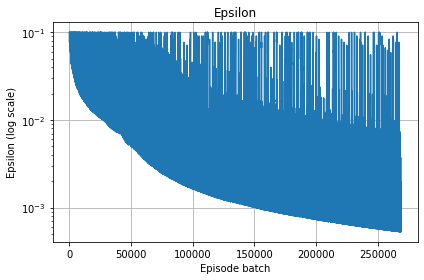

In [11]:
import matplotlib.pyplot as plt

y = evo_training['checking']['evo_epsilon']
x = range(len(y))

fig = plt.figure()
plt.plot(x, y)
plt.yscale('log')
plt.title('Epsilon')
plt.xlabel('Episode batch')
plt.ylabel('Epsilon (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Add an min for epsilon (0.1 ?)
# epsilon fixed (and compare with different plots)
# fixed alpha /learning rate
# decay rate -> multiplied by 0.99 every time
# alpha_t(a) = 1 / (1 + k_a) with k_a the number of preceding selections of action a
# ε-greedy VDBE-Boltzmann (http://www.tokic.com/www/tokicm/publikationen/papers/AdaptiveEpsilonGreedyExploration.pdf)

In [13]:
method = 'sarsa'

# Parametrisation
params = json.loads(open('src/models/value_based/sarsa/{}.json'.format(method)).read())
print(params)

{'method': 'SARSA', 'epsilon': {'init_epsilon': 1, 'decay_epsilon': 'per_state', 'min_epsilon': 0.1}, 'alpha': {'init_alpha': 1, 'decay_alpha': 'fixed', 'min_alpha': -1}, 'init_Q_type': 'ones', 'n_episodes': 1000000, 'nmax_steps': 1440, 'gamma': 0.95, 'render_episode': False, 'update_episode_division': 10}


In [ ]:
def get_epsilon(params_epsilon, episode, steps_state):
    
    if params_epsilon['decay_epsilon'] == 'fixed':
        epsilon = params_epsilon['init_epsilon']
    elif params_epsilon['decay_epsilon'] == 'per_episode':
        epsilon = params_epsilon['init_epsilon'] / (episode + 1)
    elif params_epsilon['decay_epsilon'] == 'per_state':
        epsilon = params_epsilon['init_epsilon'] / (steps_state + 1)
    elif params_epsilon['decay_epsilon'] == 'rate':
        epsilon = params_epsilon['init_epsilon'] * 0.99**episode
    else:
        print('Epsilon - Decay unknown')
        
    return max(epsilon, params_epsilon['min_epsilon'])

In [ ]:
def get_alpha(params_alpha, episode, steps_state):
    
    if params_epsilon['decay_alpha'] == 'fixed':
        alpha = params_epsilon['init_alpha']
    elif params_epsilon['decay_alpha'] == 'per_episode':
        alpha = params_epsilon['init_alpha'] / (episode + 1)
    elif params_epsilon['decay_alpha'] == 'per_state':
        alpha = params_epsilon['init_alpha'] / (steps_state + 1)
    elif params_epsilon['decay_alpha'] == 'rate':
        alpha = params_epsilon['init_alpha'] * 0.99**episode
    else:
        print('Alpha - Decay unknown')
        
    return max(alpha, params_epsilon['min_alpha'])

In [15]:
len(evo_training['checking']['evo_epsilon'])

268895

In [16]:
from src.utils.maths import running_mean

In [17]:
evo_epsilon = evo_training['checking']['evo_epsilon']

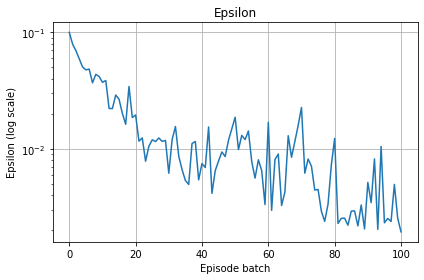

In [42]:
def get_avg_n_points(list_points, n_points):
    n_moving_points = int(np.ceil(len(list_points) / n_points))
    y_all = running_mean(evo_epsilon, n_moving_points)
    y = [list_points[0]] + [j for i,j in enumerate(y_all) if i % n_moving_points == 0] + [y_all[-1]]
    return y

y = get_avg_n_points(evo_epsilon, 100)
x = range(len(y))

fig = plt.figure()
plt.plot(x, y)
plt.yscale('log')
plt.title('Epsilon')
plt.xlabel('Episode batch')
plt.ylabel('Epsilon (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
default_Q_values = np.full(
    shape=4,
    fill_value=float('0')
)
default_Q_values

array([0., 0., 0., 0.])

In [46]:
default_Q_values = np.zeros(4)
default_Q_values

array([0., 0., 0., 0.])

In [56]:
V_max = get_discounted_reward(t=0, l_rewards_episode=np.ones(params['nmax_steps']), gamma=params['gamma'])
V_max

19.999999999999986

In [53]:
from src.features.rl_tools import get_discounted_reward

1.5553079898367456e+67

In [ ]:
parmas